In [1]:
%matplotlib inline

from __future__ import print_function

import codecs
import itertools
import re
import string

import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.engine.training import slice_X
from keras.layers import Activation, TimeDistributed, Dense, RepeatVector, recurrent

Using Theano backend.
Using gpu device 1: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN 4007)


In [2]:
with codecs.open('nguyen-nhat-anh.txt', encoding='utf8') as f:
    source_text = f.read()

print(source_text[:500])

“Cho tôi xin một vé đi tuổi thơ...”
Robert Rojdesvensky

CHƯƠNG 1

tóm lại là đã hết một ngày


Một ngày, tôi chợt nhận thấy cuộc sống thật là buồn chán và tẻ nhạt.

Năm đó tôi tám tuổi.

Sau này, tôi cũng nhiều lần thấy cuộc sống đáng chán khi thi trượt ở tuổi mười lăm, thất tình ở tuổi hăm bốn, thất nghiệp ở tuổi ba mươi ba và gặt hái mọi thành công ở tuổi bốn mươi.

Nhưng tám tuổi có cái buồn chán của tuổi lên tám.

Đó là cái ngày không hiểu sao tôi lại có ý nghĩ rằng cuộc sốn


In [3]:
# some sentences are broken into 2 lines
text = source_text.lower().replace('\n', ' ')

# and let's assume a sentence is a group of words separated by space only
sentences = [re.sub(' +', ' ', s) for s in re.findall(ur'\w[\w ]+', text, re.UNICODE)]

len(sentences)

91235

In [4]:
[print(s) for s in sentences[:5]]

cho tôi xin một vé đi tuổi thơ
robert rojdesvensky
chương 1
tóm lại là đã hết một ngày
một ngày


[None, None, None, None, None]

In [5]:
def gen_ngrams(words, n=3):
    if isinstance(words, (str, unicode)):
        words = re.split('\s+', words.strip())
    
    if len(words) < n:
        padded_words = words + ['\x00'] * (n - len(words))
        yield tuple(padded_words)
    else:
        for i in range(len(words) - n + 1):
            yield tuple(words[i: i+n])
        
print(list(gen_ngrams(' cho toi xin ', 1)))
print(list(gen_ngrams(' cho toi xin ', 2)))
print(list(gen_ngrams(' cho toi xin ', 3)))
print(list(gen_ngrams(' cho toi xin ', 4)))

[('cho',), ('toi',), ('xin',)]
[('cho', 'toi'), ('toi', 'xin')]
[('cho', 'toi', 'xin')]
[('cho', 'toi', 'xin', '\x00')]


In [6]:
NGRAMS = 5

ngrams = list(set(itertools.chain.from_iterable(gen_ngrams(s, NGRAMS) for s in sentences)))
len(ngrams)

384488

In [7]:
output_ngrams = [' '.join(t) for t in ngrams]
[print(t) for t in output_ngrams[:5]]

mận về thì có thể
cũng không nghĩ thầy hailixiro
vàng như mớ rơm khô
ra chiếc ly thằng đam
và nghe lòng mình nỗi


[None, None, None, None, None]

In [8]:
accented_chars = {
    'a': u'a á à ả ã ạ â ấ ầ ẩ ẫ ậ ă ắ ằ ẳ ẵ ặ',
    'o': u'o ó ò ỏ õ ọ ô ố ồ ổ ỗ ộ ơ ớ ờ ở ỡ ợ',
    'e': u'e é è ẻ ẽ ẹ ê ế ề ể ễ ệ',
    'u': u'u ú ù ủ ũ ụ ư ứ ừ ử ữ ự',
    'i': u'i í ì ỉ ĩ ị',
    'y': u'y ý ỳ ỷ ỹ ỵ',
    'd': u'd đ',
}

plain_char_map = {}
for c, variants in accented_chars.items():
    for v in variants.split(' '):
        plain_char_map[v] = c


def remove_accent(text):
    return u''.join(plain_char_map.get(char, char) for char in text)

remove_accent(u'tôi thấy hoa vàng trên cỏ xanh')

u'toi thay hoa vang tren co xanh'

In [9]:
input_ngrams = [remove_accent(s) for s in output_ngrams]
input_ngrams[:5]

[u'man ve thi co the',
 u'cung khong nghi thay hailixiro',
 u'vang nhu mo rom kho',
 u'ra chiec ly thang dam',
 u'va nghe long minh noi']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5bdc279190>]], dtype=object)

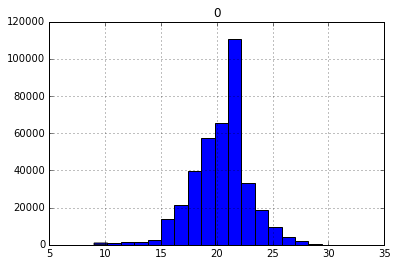

In [10]:
pd.DataFrame([len(t) for t in input_ngrams]).hist(bins=20)

In [11]:
class CharacterCodec(object):
    def __init__(self, alphabet, maxlen):
        self.alphabet = list(sorted(set(alphabet)))
        self.index_alphabet = dict((c, i) for i, c in enumerate(self.alphabet))
        self.maxlen = maxlen

    def encode(self, C, maxlen=None):
        maxlen = maxlen if maxlen else self.maxlen
        X = np.zeros((maxlen, len(self.alphabet)))
        for i, c in enumerate(C[:maxlen]):
            X[i, self.index_alphabet[c]] = 1
        return X

    def decode(self, X, calc_argmax=True):
        if calc_argmax:
            X = X.argmax(axis=-1)
        return ''.join(self.alphabet[x] for x in X)

In [12]:
MAXLEN = 32
INVERT = True

#\x00 is the padding characters
alphabet = set('\x00 _' + string.ascii_lowercase + string.digits + ''.join(plain_char_map.keys()))
codec = CharacterCodec(alphabet, MAXLEN)

print(codec.encode(u'tôi'))
print(codec.decode(codec.encode(u'tôi')))

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
tôi                             


In [13]:
X = np.zeros((len(input_ngrams), MAXLEN, len(alphabet)), dtype=np.bool)
y = np.zeros((len(output_ngrams), MAXLEN, len(alphabet)), dtype=np.bool)

for i, s in enumerate(input_ngrams):
    s += '\x00' * (MAXLEN - len(s))
    s = s[::-1] if INVERT else s
    X[i] = codec.encode(s)

for i, s in enumerate(output_ngrams):
    s += '\x00' * (MAXLEN - len(s))
    y[i] = codec.encode(s)

In [14]:
# Shuffle (X, y) in unison
indices = np.arange(len(y))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

In [15]:
# Explicitly set apart 10% for validation data that we never train over
split_at = int(len(X) - len(X) / 10)
(X_train, X_val) = (slice_X(X, 0, split_at), slice_X(X, split_at))
(y_train, y_val) = (y[:split_at], y[split_at:])

print(X_train.shape)
print(y_train.shape)

(346040, 32, 106)
(346040, 32, 106)


In [ ]:
print('Build model...')

# Try replacing GRU, or SimpleRNN
RNN = recurrent.LSTM
HIDDEN_SIZE = 1024
LAYERS = 1

model = Sequential()
# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE
# note: in a situation where your input sequences have a variable length,
# use input_shape=(None, nb_feature).
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(alphabet)), consume_less='gpu'))
# For the decoder's input, we repeat the encoded input for each time step
model.add(RepeatVector(MAXLEN))
# The decoder RNN could be multiple layers stacked or a single layer
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True, consume_less='gpu'))

# For each of step of the output sequence, decide which character should be chosen
model.add(TimeDistributed(Dense(len(alphabet))))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Build model...


In [ ]:
for i in range(50):
    model.fit(X_train, y_train,
              batch_size=128, nb_epoch=1,
              validation_data=(X_val, y_val))

    for i in range(3):
        ind = np.random.randint(0, len(X_val))
        rowX, rowy = X_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowX, verbose=0)
        test = codec.decode(rowX[0])
        correct = codec.decode(rowy[0])
        guess = codec.decode(preds[0], calc_argmax=False)
        print(u'T: "{}"'.format(test[::-1] if INVERT else test))
        print(u'C: "{}"'.format(correct))
        print(u'{} "{}"'.format(u'✅' if correct == guess else u'❌', guess))
        print('---')

Train on 346040 samples, validate on 38448 samples
Epoch 1/1
346040/346040 [==============================] - 600s - loss: 0.9479 - acc: 0.7605 - val_loss: 0.2383 - val_acc: 0.9309
T: "mat yan dran luc ngay           "
C: "mặt yan dran lúc ngày           "
❌ "mặt aần guan lúc ngay           "
---
T: "chac ba                         "
C: "chắc ba                         "
✅ "chắc ba                         "
---
T: "den muc khong the hoac          "
C: "đến mức không thể hoặc          "
❌ "đến mức không thể hoác          "
---
Train on 346040 samples, validate on 38448 samples
Epoch 1/1
346040/346040 [==============================] - 606s - loss: 0.2348 - acc: 0.9323 - val_loss: 0.1709 - val_acc: 0.9488
T: "voi dieu kien nguoi vo          "
C: "với điều kiện người vợ          "
❌ "với điều kiến người vô          "
---
T: "uoc ma hai dua no               "
C: "ước mà hai đứa nó               "
❌ "ưốc mà hai đứa nó               "
---
T: "thich nhat cau noi cua          "
C: "thích nhất 

KeyboardInterrupt: 

In [18]:
for i in range(10):
    ind = np.random.randint(0, len(X_val))
    rowX, rowy = X_val[np.array([ind])], y_val[np.array([ind])]
    preds = model.predict_classes(rowX, verbose=0)
    test = codec.decode(rowX[0])
    correct = codec.decode(rowy[0])
    guess = codec.decode(preds[0], calc_argmax=False)
    print(u'T: "{}"'.format(test[::-1] if INVERT else test))
    print(u'C: "{}"'.format(correct))
    print(u'{} "{}"'.format(u'✅' if correct == guess else u'❌', guess))
    print('---')

T: "tre ngoan nao lai nhay          "
C: "trẻ ngoan nào lại nhảy          "
✅ "trẻ ngoan nào lại nhảy          "
---
T: "ra dao hoang hay vo             "
C: "ra đảo hoang hay vô             "
❌ "ra dão hoang hay vô             "
---
T: "nhung nguoi hay dau tien        "
C: "những người hay đầu tiên        "
✅ "những người hay đầu tiên        "
---
T: "lap lai chang duong xua         "
C: "lặp lại chặng đường xưa         "
❌ "lấp lại chẳng đường xưa         "
---
T: "noi trum bastu dich than        "
C: "nói trùm bastu đích thân        "
✅ "nói trùm bastu đích thân        "
---
T: "chac ba                         "
C: "chắc ba                         "
❌ "chắc bà                         "
---
T: "tho tay ra sau lung             "
C: "thò tay ra sau lưng             "
✅ "thò tay ra sau lưng             "
---
T: "ngoi xuong duoi chan mot        "
C: "ngồi xuống duỗi chân một        "
❌ "ngồi xuống dưới chân một        "
---
T: "nho lai va phai noi             "
C: "nhỏ lại và phải nói   

In [110]:
from collections import Counter

def guess(ngram):
    text = ' '.join(ngram)
    text += '\x00' * (MAXLEN - len(text))
    if INVERT:
        text = text[::-1]
    preds = model.predict_classes(np.array([codec.encode(text)]), verbose=0)
    return codec.decode(preds[0], calc_argmax=False)


def add_accent(text):
    ngrams = gen_ngrams(text.lower(), n=NGRAMS)
    guessed_ngrams = list(guess(ngram) for ngram in ngrams)
    candidates = [Counter() for _ in range(len(guessed_ngrams) + NGRAMS - 1)]
    for nid, ngram in enumerate(guessed_ngrams):
        for wid, word in enumerate(ngram.split(' ')):
            candidates[nid + wid].update([word])
    return ' '.join(c.most_common(1)[0][0] for c in candidates).strip('\x00 ')

In [153]:
print(add_accent('co gai den tu hom qua'))

cô gái đến từ hôm                qua
